In [7]:
import matplotlib.pyplot as plt
import numpy as np
from pyslfp import FingerPrint, plot, IceModel
from joblib import Parallel, delayed
import pandas as pd
import seaborn as sns

from Part_III_Project import sea_surface_height_change as sshc

sns.set_theme(style="ticks", palette="muted")

## Variable setting

In [8]:
lmax = 128

resolution = 40  # number of points from -90 to 90 degrees

fields = 1000

# length_scales = [0.005, 0.1]
length_scales = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

## Pre-calculate length scales and resolutions

In [9]:
satellite_ranges = np.round(np.linspace(1, 90, resolution), 2)
fp = FingerPrint(lmax=lmax)
fp.set_state_from_ice_ng(version=IceModel.ICE7G, date=0.0)

X = fp.lebesgue_load_space()


# Function to generate a single sample for a given length scale
def generate_single_sample(length_scale, sample_idx):
    mu = X.heat_kernel_gaussian_measure(length_scale * fp.mean_sea_floor_radius)
    return length_scale, sample_idx, mu.sample()


# Generate all combinations of length scales and sample indices
tasks = [
    (length_scale, sample_idx)
    for length_scale in length_scales
    for sample_idx in range(fields)
]

print(
    f"Generating {len(tasks)} total samples across {len(length_scales)} length scales..."
)

# Parallelize all sample generation at once
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(generate_single_sample)(length_scale, sample_idx)
    for length_scale, sample_idx in tasks
)

# Organize results by length scale
all_errors = {ls: {"fields": []} for ls in length_scales}

for length_scale, sample_idx, sample in results:
    all_errors[length_scale]["fields"].append(sample)

# Convert lists to numpy arrays
for length_scale in length_scales:
    all_errors[length_scale]["fields"] = np.array(all_errors[length_scale]["fields"])


Generating 6000 total samples across 6 length scales...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19780565850530826s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14599013328552246s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    2.0s
[P

## Precompute altimetry weighting functions for all satellite ranges in parallel

In [10]:
def compute_altimetry_weighting_function(satellite_range):
    """Compute altimetry weighting function for a given satellite range."""
    altimetry_projection = fp.altimetry_projection(
        latitude_min=-satellite_range, latitude_max=satellite_range, value=0
    )
    altimetry_projection_integral = fp.integrate(altimetry_projection)
    altimetry_weighting_function = altimetry_projection / altimetry_projection_integral
    return altimetry_weighting_function


altimetry_weighting_functions = Parallel(n_jobs=-1, verbose=10)(
    delayed(compute_altimetry_weighting_function)(satellite_range)
    for satellite_range in satellite_ranges
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007990360260009766s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of  40 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of  40 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  40 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  17 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


## Function setting

In [11]:
def compute_sshchange_and_mean_for_field(field):
    """Compute sea surface height change and mean sea level change for a given field."""
    direct_load = field * fp.ice_projection(value=0)

    (
        sea_level_change,
        displacement,
        gravitational_potential_change,
        angular_velocity_change,
    ) = fp(direct_load=direct_load)

    sshchange = sshc(
        fp,
        sea_level_change,
        displacement,
        angular_velocity_change,
    )

    mean_sea_level_change = fp.mean_sea_level_change(direct_load)

    return sshchange, mean_sea_level_change


def compute_error_for_satellite_range(
    sshchange, mean_sea_level_change, altimetry_weighting_function
):
    """Compute estimation error for a given satellite range."""
    mean_sea_level_change_estimate = fp.integrate(
        altimetry_weighting_function * sshchange
    )

    error = (
        100
        * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
        / np.abs(mean_sea_level_change)
    )
    return error


data = pd.DataFrame()


def compute_all_for_field_and_satrange(
    length_scale, field, sat_range, altimetry_weighting_function
):
    """Compute SSH change, mean sea level change, and error for a specific field and satellite range."""
    direct_load = field * fp.ice_projection(value=0)

    (
        sea_level_change,
        displacement,
        gravitational_potential_change,
        angular_velocity_change,
    ) = fp(direct_load=direct_load)

    sshchange = sshc(
        fp,
        sea_level_change,
        displacement,
        angular_velocity_change,
    )

    mean_sea_level_change = fp.mean_sea_level_change(direct_load)

    mean_sea_level_change_estimate = fp.integrate(
        altimetry_weighting_function * sshchange
    )

    error = (
        100
        * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
        / np.abs(mean_sea_level_change)
    )

    return {
        "length_scale": length_scale,
        "sat_range": sat_range,
        "error": error,
        "true_mean": mean_sea_level_change,
        "estimate": mean_sea_level_change_estimate,
    }


## Calc. SLC and SSHC and error

In [12]:
print(f"Number of jobs is {len(length_scales) * fields * resolution}")

# save errors, estimates, and true means for all in a dataframe, use parallel processing
# # Create all combinations of tasks
tasks = [
    (length_scale, field, sat_range, altimetry_weighting_function)
    for length_scale in length_scales
    for field in all_errors[length_scale]["fields"]
    for sat_range, altimetry_weighting_function in zip(
        satellite_ranges, altimetry_weighting_functions
    )
]

print(f"Processing {len(tasks)} total combinations in parallel...")

# Execute all tasks in a single parallel batch
results = Parallel(n_jobs=-1, verbose=2)(
    delayed(compute_all_for_field_and_satrange)(
        length_scale, field, sat_range, altimetry_weighting_function
    )
    for length_scale, field, sat_range, altimetry_weighting_function in tasks
)

# Extract results into lists
error_list = [r["error"] for r in results]
true_mean_list = [r["true_mean"] for r in results]
estimate_list = [r["estimate"] for r in results]
satallite_range_list = [r["sat_range"] for r in results]
length_scale_list = [r["length_scale"] for r in results]

Number of jobs is 240000
Processing 240000 total combinations in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1834 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 2724 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 3778 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 6370 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 7908 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 9610 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 11472 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 13498 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 15684 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 18034 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 20544 tasks

In [20]:
# into dataframe

data = pd.DataFrame(
    {
        "length_scale": length_scale_list,
        "satellite_range": satallite_range_list,
        "error": error_list,
        "true_mean": true_mean_list,
        "estimate": estimate_list,
    }
)
data["num_error"] = data["estimate"] - data["true_mean"]
data.to_csv("random_field_errors.csv", index=False)

In [33]:
# read
data = pd.read_csv("random_field_errors.csv")

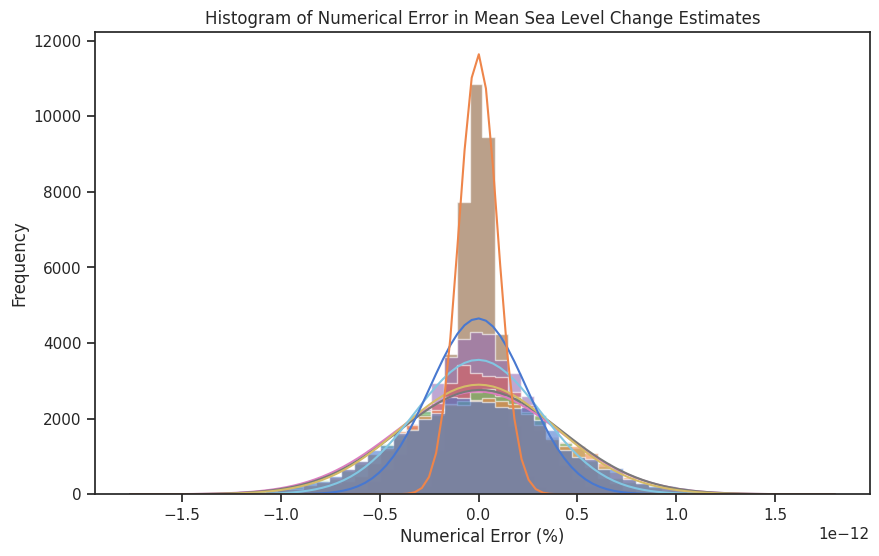

In [29]:
# histogram of numerical error per length scale
plt.figure(figsize=(10, 6))
plt.hist(
    [data[data["length_scale"] == ls]["num_error"] for ls in length_scales],
    bins=50,
    label=[f"Length Scale {ls}" for ls in length_scales],
    alpha=0.6,
    density=False,
    histtype="stepfilled",
)

# Overlay Gaussian distribution using seaborn and colors from the histogram
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
for length_scale in length_scales:
    subset = data[data["length_scale"] == length_scale]["num_error"]
    mu = subset.mean()
    sigma = subset.std()
    p = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    plt.plot(
        x, p * len(subset) * (xmax - xmin) / 50, label=f"Gaussian Fit LS {length_scale}"
    )

# plt.yscale("log")
plt.title("Histogram of Numerical Error in Mean Sea Level Change Estimates")
plt.xlabel("Numerical Error (%)")
plt.ylabel("Frequency")
plt.show()

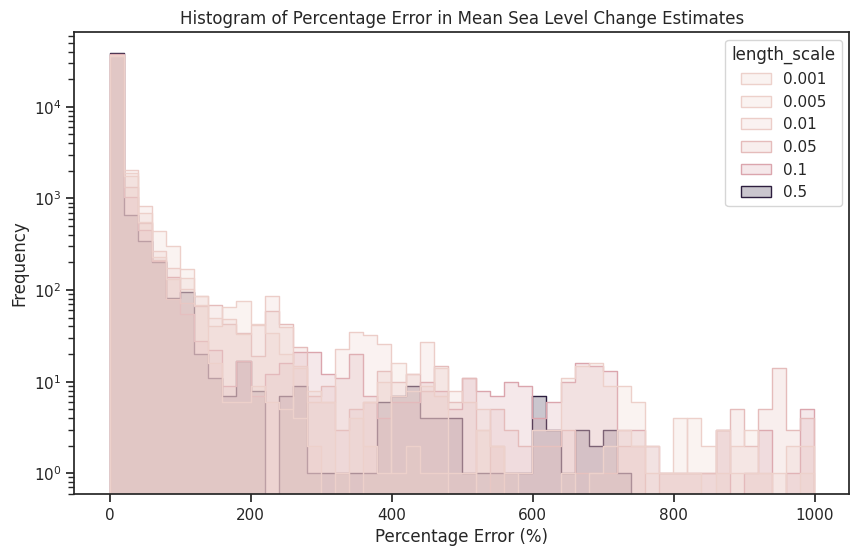

In [32]:
# histogram of error
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x="error", bins=50, hue="length_scale", element="step")
# log y axis
plt.yscale("log")
plt.title("Histogram of Percentage Error in Mean Sea Level Change Estimates")
plt.xlabel("Percentage Error (%)")
plt.ylabel("Frequency")
plt.show()

In [31]:
# remove any rows where error is over 300
data = data[data["error"] <= 1000]

In [18]:
# print range of error:
print(f"Error ranges from {data['error'].min()} to {data['error'].max()}")

Error ranges from 3.884204562456084e-05 to 999.2224802919033


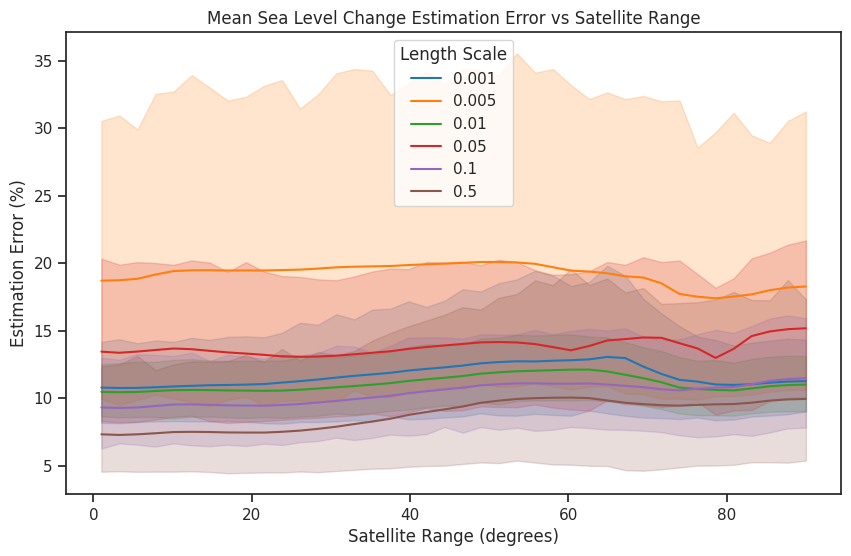

In [36]:
# plot error vs satellite range
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=data,
    x="satellite_range",
    y="error",
    hue="length_scale",
    palette="tab10",
)

plt.title("Mean Sea Level Change Estimation Error vs Satellite Range")
plt.xlabel("Satellite Range (degrees)")
plt.ylabel("Estimation Error (%)")
plt.legend(title="Length Scale")